<a href="https://colab.research.google.com/github/KBVKarthik/Keras-Computer-Vision-Models/blob/main/RandAugment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
pip install imgaug

In [93]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from imgaug import augmenters as iaa
import imgaug as ia

tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)

In [94]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


In [95]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 1
IMAGE_SIZE = 72

In [96]:
rand_aug = iaa.RandAugment(n=3, m=7)


def augment(images):

    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

In [97]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

In [98]:
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)


train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

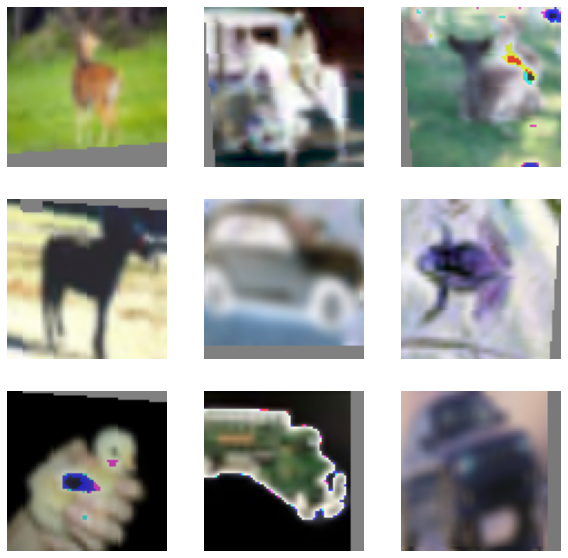

In [99]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

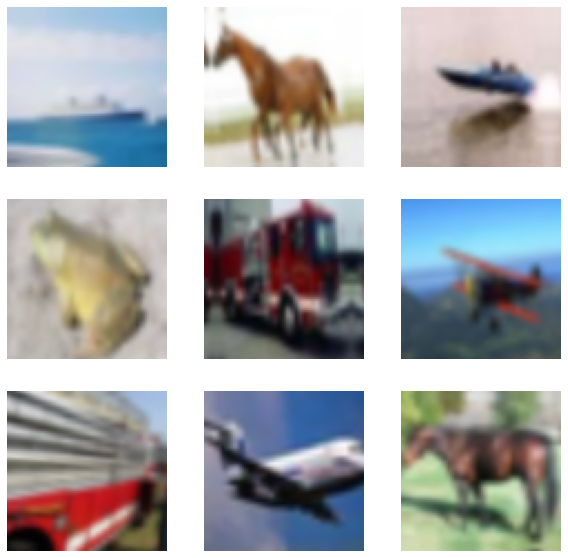

In [100]:
sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [101]:
def get_training_model():
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None,
        include_top=True,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        classes=10,
    )
    model = tf.keras.Sequential(
        [
            layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
            layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
        ]
    )
    return model


get_training_model().summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 72, 72, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 10)                23585290  
Total params: 23,585,290
Trainable params: 23,539,850
Non-trainable params: 45,440
_________________________________________________________________


In [102]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

In [103]:
rand_aug_model = get_training_model()
rand_aug_model.load_weights("initial_weights.h5")
rand_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
rand_aug_model.fit(train_ds_rand, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = rand_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

79/79 [==============================] - 10s 127ms/step - loss: 1.6549 - accuracy: 0.4523
Test accuracy: 45.23%


In [104]:
simple_aug_model = get_training_model()
simple_aug_model.load_weights("initial_weights.h5")
simple_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_aug_model.fit(train_ds_simple, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = simple_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

79/79 [==============================] - 10s 128ms/step - loss: 1.4982 - accuracy: 0.5123
Test accuracy: 51.23%


In [105]:
cifar_10_c = tfds.load("cifar10_corrupted/saturate_5", split="test", as_supervised=True)
cifar_10_c = cifar_10_c.batch(BATCH_SIZE).map(
    lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
    num_parallel_calls=AUTO,
)


_, test_acc = rand_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with RandAugment on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)


_, test_acc = simple_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with simple_aug on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10_corrupted/saturate_5/1.0.0.incompleteAILLWZ/cifar10_corrupted-test.tfrecord
Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/saturate_5/1.0.0. Subsequent calls will reuse this data.
Accuracy with RandAugment on CIFAR-10-C (saturate_5): 40.04%
Accuracy with simple_aug on CIFAR-10-C (saturate_5): 41.50%
